In [ ]:

!pip uninstall -y torch torchvision torchaudio transformers accelerate bitsandbytes


!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


!pip install -q --upgrade transformers datasets accelerate evaluate scikit-learn pandas openpyxl geopy sentence-transformers peft ftfy seaborn matplotlib bitsandbytes country_converter pycountry optuna






In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import re
import json
import time
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    AutoModelForSequenceClassification,
    pipeline,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from tqdm.auto import tqdm
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable, GeocoderServiceError
from sentence_transformers import SentenceTransformer, util
import ftfy
from peft import LoraConfig, get_peft_model, TaskType
import evaluate
import difflib
import optuna
from huggingface_hub import login
from getpass import getpass
from google.colab import userdata
import huggingface_hub
import torch
from torch import nn
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, pipeline
import torch
from sklearn.metrics import classification_report

In [ ]:
hf_token = userdata.get('HF_TOKEN').strip()
huggingface_hub.login(token=hf_token)


Successfully logged into Hugging Face.


In [ ]:
test_df = pd.read_excel('news_classification_test_dataset.xlsx')

In [ ]:
test_df.columns = test_df.iloc[0]

test_df = test_df.drop(0)


test_df = test_df.reset_index(drop=True)

In [ ]:
# small_test_df = test_df.sample(frac=0.1, random_state=42)
# small_test_df.shape
# small_test_df.head()

In [ ]:
test_df['Article'] = test_df['Headline'].fillna('').astype(str) + '\n\n' + test_df['Content'].fillna('').astype(str)

In [ ]:
def advanced_text_cleaner(text: str) :


    text = ftfy.fix_text(text)


    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)


    text = re.sub(r'\S*@\S*\s?', '', text, flags=re.MULTILINE)

    boilerplate_patterns = [
        r'Breaking News',
        r'Kindly share this story:',
        r'All rights reserved\.',
        r'This material, and other digital content on this website, may not be reproduced.*',
        r'punchng.com ©.*',
        r'Contact:.*'
    ]
    for pattern in boilerplate_patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)


    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
test_df['Article_Clean'] = test_df['Article'].apply(advanced_text_cleaner)

In [ ]:
test_df = test_df[['Article_Clean','Category']].copy()

In [ ]:
categories = test_df['Category'].unique().tolist()

print(f"Data shape: {test_df.shape}")
print(f"Categories found: {categories}")


--- Test Data Ready ---
Data shape: (856, 2)
Categories found: ['Civil unrest', 'Other', 'Crime', 'Road traffic accident', 'Kidnapping', 'Environmental & Infrastructure', 'Terrorism and political violence acts', 'Medical']


In [ ]:
test_df.head()

,Article_Clean,Category
0,Govt reopens Kwara college after five-week clo...,Civil unrest
1,"Replace Tinubu as candidate, Atiku's spokesper...",Other
2,Aregbesola backs community participation in ta...,Other
3,"Atiku-Okowa campaign, PDP govs hail Adeleke on...",Other
4,Soldiers kill four bandits in Kaduna LGA Ogun ...,Crime


In [ ]:
########################### WITH SUMMARY INCLUDED, GENERATING THE SUMMARY WAS DONE DOWN


test_df= pd.read_excel('llama3_zeroshot_summary_results.xlsx')
test_df.head()

,Article_Clean,Category,Generated_Summary,Final_Summary,LLM_Predicted
0,Govt reopens Kwara college after five-week clo...,Civil unrest,Here is a three-sentence summary of the articl...,The Kwara State Government has reopened the Kw...,Civil unrest
1,"Replace Tinubu as candidate, Atiku's spokesper...",Other,Here is a summary of the article in three conc...,"Phrank Shaibu, Special Assistant to Atiku Abub...",Other
2,Aregbesola backs community participation in ta...,Other,Here is a summary of the article in three conc...,"Minister of Interior, Rauf Aregbesola, has emp...",Other
3,"Atiku-Okowa campaign, PDP govs hail Adeleke on...",Other,Here is a summary of the article in three conc...,The Atiku-Okowa Presidential Campaign Organisa...,Other
4,Soldiers kill four bandits in Kaduna LGA Ogun ...,Crime,Here is a summary of the article in three conc...,Troops from Operation Forest Sanity neutralize...,Terrorism and political violence acts


In [ ]:
test_df = test_df[['Final_Summary','Category']].copy()

In [ ]:
categories = test_df['Category'].unique().tolist()

print(f"Data shape: {test_df.shape}")
print(f"Categories found: {categories}")


--- Test Data Ready ---
Data shape: (856, 2)
Categories found: ['Civil unrest', 'Other', 'Crime', 'Road traffic accident', 'Kidnapping', 'Environmental & Infrastructure', 'Terrorism and political violence acts', 'Medical']


In [ ]:
MODEL_ID = "meta-llama/Meta-Llama-3-8B-Instruct"
BATCH_SIZE = 16


quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)


model_llm = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=quantization_config,
    device_map="auto",

)
tokenizer_llm = AutoTokenizer.from_pretrained(MODEL_ID)
print("Model loaded successfully.")

Loading model: meta-llama/Meta-Llama-3-8B-Instruct...


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Model loaded successfully.


In [ ]:
pipe = pipeline(
    "text-generation",
    model=model_llm,
    tokenizer=tokenizer_llm,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

Device set to use cuda:0


In [ ]:
if pipe.tokenizer.pad_token is None:
    pipe.tokenizer.pad_token = pipe.tokenizer.eos_token


Tokenizer padding token configured for batching.


In [ ]:
category_definitions = {

    "Terrorism and political violence acts":
        "Use when organised armed actors (militants, insurgents, separatists, unknown gunmen) "
        "attack civilians or state targets **to intimidate or coerce**. A clear political / "
        "ideological motive OR a pattern of armed raids counts, even if no ransom is demanded. "
        "EXCLUDE: hostage-taking for ransom only → Kidnapping; spontaneous crowds → Civil unrest.",

    "Kidnapping":
        "Any seizure or abduction of people (hostage-taking, crew hijack, child snatch, ‘one-chance’ robberies) "
        "where **the primary act is holding victims**. Motive may be ransom, robbery or revenge. "
        "EXCLUDE: abduction named as part of an armed political attack → Terrorism; no persons seized → Crime.",

    "Civil unrest":
        "Crowd actions such as protests, strikes, road blockages or riots **without organised use of guns or bombs**. "
        "EXCLUDE: armed assault or bomb attack during a protest → Terrorism; single-perpetrator thefts → Crime.",

    "Road traffic accident":
        "Unintentional collision or vehicle crash on roads causing injury, death or traffic delay. "
        "EXCLUDE: driver deliberately rams for ideological reasons → Terrorism; crash triggered by flood/landslide → Environmental & Infrastructure.",


    "Crime":
        "Any punishable act (theft, robbery, assault, fraud, homicide) **that is NOT abduction and NOT politically-motivated violence**. "
        "EXCLUDE: any hostage-taking → Kidnapping; attack by militants or insurgents → Terrorism.",

    "Environmental & Infrastructure":
        "Natural disasters (flood, storm, quake, wildfire, landslide) OR infrastructure / utility failures "
        "(bridge collapse, power-grid outage, dam burst, major road closure). "
        "EXCLUDE: routine vehicle crashes → Road traffic accident; stories focused on health policy → Medical.",

    "Medical":
        "Disease outbreaks, epidemics, infections, heatwaves, public-health advisories **and active health-emergency responses**. "
        "EXCLUDE: general health-agency staffing, budgets or lab upgrades with no urgent health threat → Other.",

    "Other":
        "Everything else: elections, economics, business, culture, science **unless** the story fits one of the definitions above. "
        "EXCLUDE: any article mentioning an abduction, armed attack, disease outbreak, natural disaster, or power/bridge failure.",
}
definitions_str = "\n".join([f"- '{name}': {desc}" for name, desc in category_definitions.items()])



In [ ]:
def create_zeroshot_prompt(article_text: str,  category_list: list[str]):

    cats_json = ", ".join(f'"{c}"' for c in category_list)
    system = (
        "You are a strict news-classification engine.\n"
        "• Reply with **exactly** one JSON object whose only key is \"label\".\n"
        f"• The value of \"label\" MUST be one of: [{cats_json}].\n"
        "• If you are uncertain, pick the single best-matching category.\n"
        "• Base your choice **solely on the definitions and the article text**."
    )

    user = f"""
Classify the article below.

Definitions:
{definitions_str}

ARTICLE
-------
{article_text}
-------

────────────────────────────────────
Reply *only* with a JSON object
────────────────────────────────────
""".strip()

    msgs = [
        {"role": "system", "content": system},
        {"role": "user",   "content": user}
    ]
    prompt=pipe.tokenizer.apply_chat_template(
        msgs, tokenize=False, add_generation_prompt=True
    )
    prompt = prompt.replace(tokenizer_llm.eos_token +
                        "<|start_header_id|>assistant<|end_header_id|>",
                        "<|start_header_id|>assistant<|end_header_id|>")
    return prompt

def parse_llm_response(resp: str, valid_categories: list[str]):

    _, _, assistant = resp.rpartition("<|start_header_id|>assistant<|end_header_id|>")
    if not assistant:
        assistant = resp

    for m in reversed(list(re.finditer(r"\{[^{}]*\}", assistant, flags=re.DOTALL))):
        try:
            label = json.loads(m.group())["label"].strip()
            if label in valid_categories:
                return label
        except Exception:
            continue
    pats = "|".join(re.escape(c) for c in valid_categories)
    m = re.search(rf"\b({pats})\b", assistant, flags=re.IGNORECASE)
    if m:
        return next(c for c in valid_categories if c.lower() == m.group(1).lower())

    print("\n\nResponse of the text: ", resp,"\n")
    return "Invalid Output"


def _fallback_best_match(text: str, valid_categories: list[str]) -> str:

    match = difflib.get_close_matches(text, valid_categories, n=1, cutoff=0.0)
    print(match)
    return match[0] if match else "Invalid Output"

In [ ]:


prompts = [create_zeroshot_prompt(article, categories) for article in test_df['Final_Summary']]
print(f"{len(prompts)} prompts created.")
prompts[1]

In [ ]:
outputs = pipe(prompts, max_new_tokens=100, do_sample=False  ,batch_size=BATCH_SIZE)
print("Batched inference complete.")


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more de

Batched inference complete.


In [ ]:
llm_predictions = [parse_llm_response(result[0]['generated_text'], categories) for result in tqdm(outputs, desc="Parsing results")]


Parsing results:   0%|          | 0/856 [00:00<?, ?it/s]

In [ ]:
test_df['LLM_Predicted'] = llm_predictions
true_labels = test_df['Category']

In [ ]:






accuracy = accuracy_score(true_labels, llm_predictions)
f1_macro = f1_score(true_labels, llm_predictions, average='macro', labels=categories, zero_division=0)
precision_macro = precision_score(true_labels, llm_predictions, average='macro', labels=categories, zero_division=0)
recall_macro = recall_score(true_labels, llm_predictions, average='macro', labels=categories, zero_division=0)

report_dict = {
    "accuracy": accuracy,
    "f1_macro": f1_macro,
    "precision_macro": precision_macro,
    "recall_macro": recall_macro
}

print("\n--- Key Performance Metrics ---")
for metric, value in report_dict.items():
    print(f"{metric:<18}: {value:.4f}")



all_possible_outcomes = categories + ['Invalid Output'] if 'Invalid Output' in set(llm_predictions) else categories
full_report = classification_report(
    true_labels,
    llm_predictions,
    labels=all_possible_outcomes,
    target_names=all_possible_outcomes,
    zero_division=0
)
print(full_report)
print("="*80)


try:
    test_df[['Article_Summary', 'Category', 'LLM_Predicted']].to_excel("llama3_zeroshot_results_small_dataset.xlsx", index=False)
    print(f"\nFull results with predictions saved to 'llama3_zeroshot_results_colab.xlsx'")

except Exception as e:
    print(f"\nCould not save results to Excel. Error: {e}")


               Final Performance Report for meta-llama/Meta-Llama-3-8B-Instruct

--- Key Performance Metrics ---
accuracy          : 0.7932
f1_macro          : 0.8083
precision_macro   : 0.8147
recall_macro      : 0.8186

--- Detailed Classification Report (including invalid outputs) ---
                                       precision    recall  f1-score   support

                         Civil unrest       0.88      0.87      0.87       114
                                Other       0.83      0.63      0.72       201
                                Crime       0.78      0.64      0.71       101
                Road traffic accident       0.95      0.94      0.94        62
                           Kidnapping       0.98      0.84      0.90       111
       Environmental & Infrastructure       0.81      0.89      0.85        53
Terrorism and political violence acts       0.62      0.79      0.69        85
                              Medical       0.66      0.96      0.78       12

In [ ]:
for i, result in enumerate(outputs[:20]):
    raw_response_text = result[0]['generated_text']

    parsed_category = parse_llm_response(raw_response_text, categories)

    print(f"\n----------- Article {i+1} -----------")
    print(f"RAW OUTPUT:\n{repr(raw_response_text)}")
    print("-" * 20)
    print(f"PARSED RESULT: '{parsed_category}'")
    print("-" * 20)


--- Comparing Raw Output vs. Parsed Output ---

----------- Article 1 -----------
RAW OUTPUT:
'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou are a strict news-classification engine.\n• Reply with **exactly** one JSON object whose only key is "label".\n• The value of "label" MUST be one of: ["Civil unrest", "Other", "Crime", "Road traffic accident", "Kidnapping", "Environmental & Infrastructure", "Terrorism and political violence acts", "Medical"].\n• If you are uncertain, pick the single best-matching category.\n• Base your choice **solely on the definitions and the article text**.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nClassify the article below.\n\nDefinitions:\n- \'Terrorism and political violence acts\': Use when organised armed actors (militants, insurgents, separatists, unknown gunmen) attack civilians or state targets **to intimidate or coerce**. A clear political / ideological motive OR a pattern of armed raids counts, even if no ransom is de

--- Generating Confusion Matrix ---

Confusion Matrix (Raw Counts):
                                       Civil unrest  Other  Crime  \
Civil unrest                                     99     10      1   
Other                                             2    126      1   
Crime                                             6      5     65   
Road traffic accident                             0      3      0   
Kidnapping                                        0      3      3   
Environmental & Infrastructure                    2      0      1   
Terrorism and political violence acts             4      1     12   
Medical                                           0      3      0   

                                       Road traffic accident  Kidnapping  \
Civil unrest                                               0           0   
Other                                                      0           0   
Crime                                                      0           1   
Road t

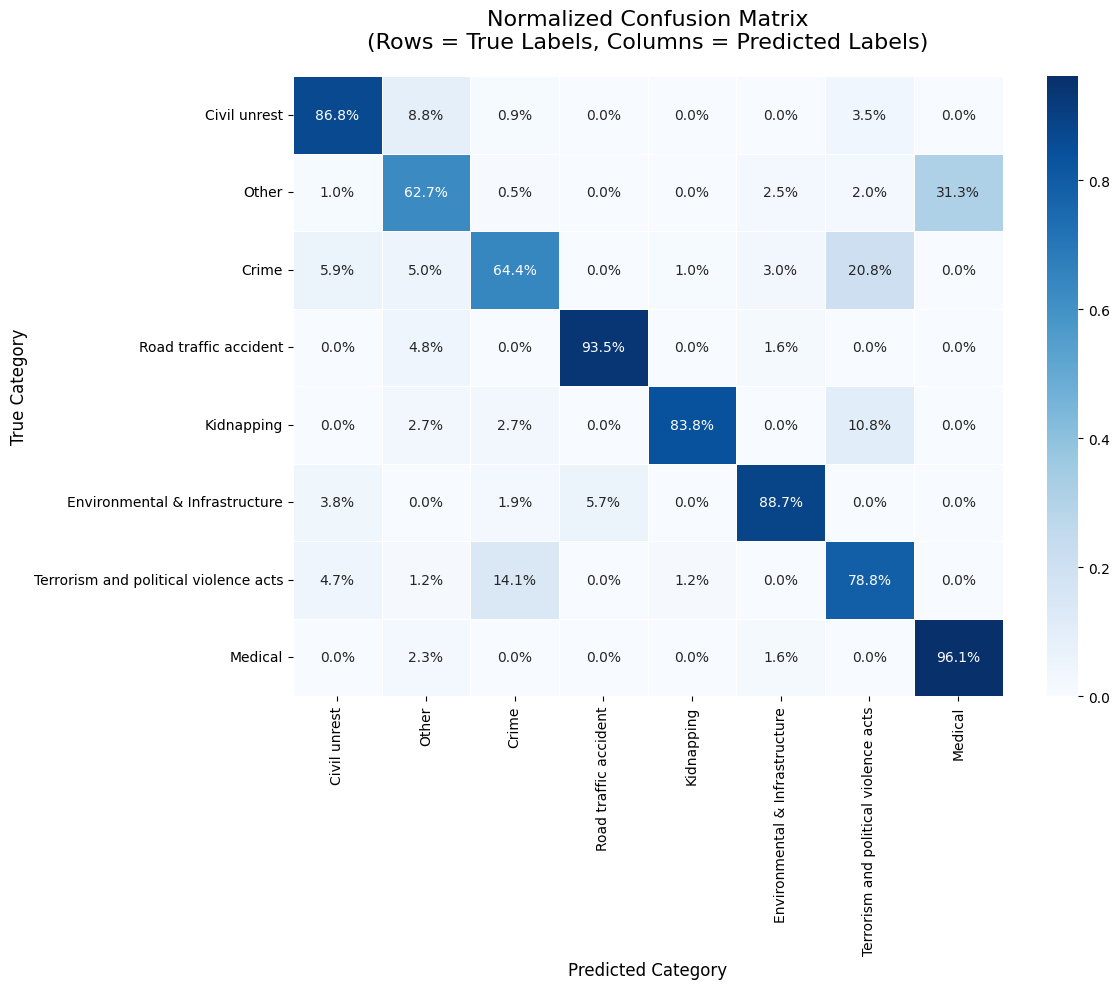

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(true_labels, llm_predictions, labels=categories)


cm_df = pd.DataFrame(cm, index=categories, columns=categories)

print("\nConfusion Matrix :")
print(cm_df)



cm_normalized = cm_df.div(cm_df.sum(axis=1), axis=0)



plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.1%',
    cmap='Blues',
    linewidths=.5
)


heatmap.set_title('Normalized Confusion Matrix\n(Rows = True Labels, Columns = Predicted Labels)', fontsize=16, pad=20)
heatmap.set_xlabel('Predicted Category', fontsize=12)
heatmap.set_ylabel('True Category', fontsize=12)


plt.tight_layout()
plt.show()

/tmp/ipython-input-1888717186.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rep_sorted.index, y=rep_sorted['recall'], palette='viridis', errorbar=None)


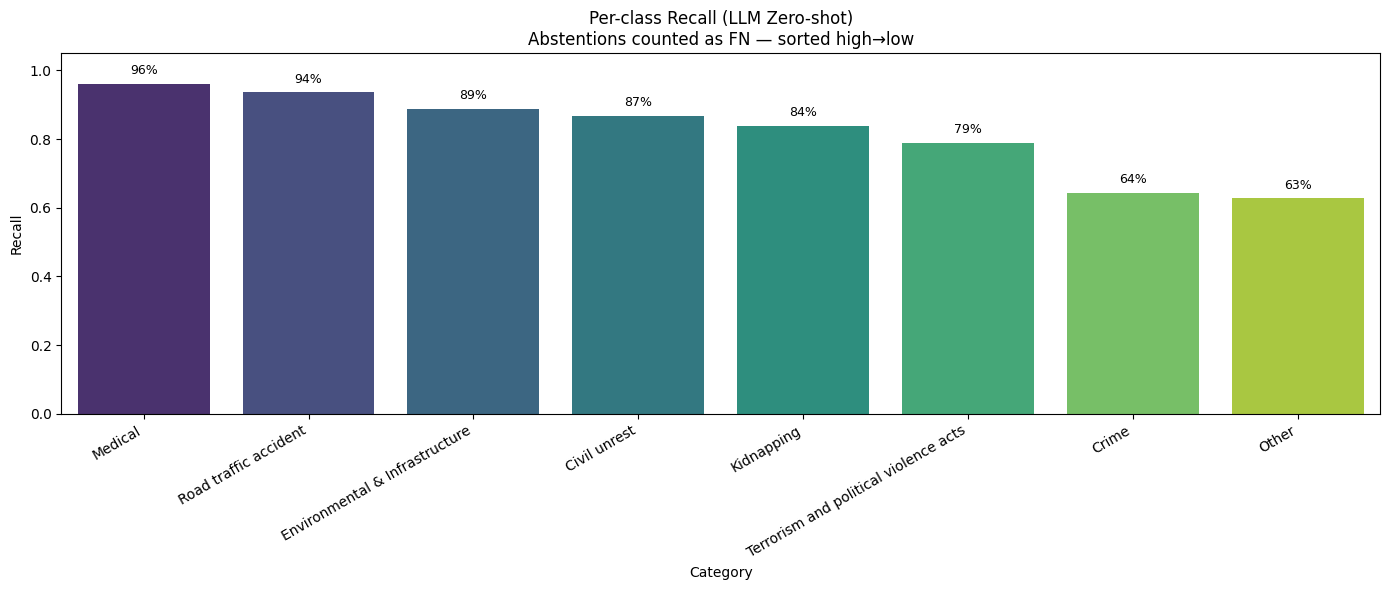

Abstained/invalid predictions: 0 / 856 (0.0%)


In [ ]:

import seaborn as sns
from sklearn.metrics import classification_report


labels = list(categories)

y_true = test_df['Category'].astype(str).str.strip()
y_pred_raw = test_df['LLM_Predicted'].astype('string').str.strip()


ABSTAIN_TOKEN = "ABSTAIN"
y_pred = y_pred_raw.where(y_pred_raw.isin(labels), ABSTAIN_TOKEN)
n_abstain = (y_pred == ABSTAIN_TOKEN).sum()

report = classification_report(
    y_true, y_pred,
    labels=labels,
    target_names=labels,
    output_dict=True,
    zero_division=0
)
rep_df = pd.DataFrame(report).T.loc[labels]


order = rep_df['recall'].fillna(0).sort_values(ascending=False).index
rep_sorted = rep_df.loc[order]


plt.figure(figsize=(14, 6))
sns.barplot(x=rep_sorted.index, y=rep_sorted['recall'], palette='viridis', errorbar=None)
plt.title('Per-class Recall (LLM Zero-shot)\nAbstentions counted as FN — sorted high→low')
plt.xlabel('Category')
plt.ylabel('Recall')
plt.ylim(0, 1.05)
plt.xticks(rotation=30, ha='right')


for i, v in enumerate(rep_sorted['recall'].values):
    plt.text(i, min(v + 0.02, 1.02), f"{v:.0%}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"Abstained/invalid predictions: {n_abstain} / {len(y_pred)} "
      f"({n_abstain/len(y_pred):.1%})")


In [ ]:

prediction_counts = test_df['LLM_Predicted'].value_counts()


print(prediction_counts)

--- Counts of Each Predicted Category ---
LLM_Predicted
Crime                                    165
Medical                                  141
Other                                    134
Invalid Output                            96
Civil unrest                              93
Terrorism and political violence acts     68
Road traffic accident                     58
Kidnapping                                51
Environmental & Infrastructure            50
Name: count, dtype: int64


In [ ]:
DEBUG_ARTICLE = "Police say three gunmen abducted two students..."
prompt = create_revised_zeroshot_prompt(DEBUG_ARTICLE, categories)

ids = tokenizer_llm(prompt, return_tensors="pt").input_ids.to(model_llm.device)
print("last IDs:", ids[0, -5:].tolist())

out_ids = model_llm.generate(ids,
                         max_new_tokens=50,
                         do_sample=False)
print("DECODED:\n", tokenizer_llm.decode(out_ids[0]))

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


last IDs: [33423, 128006, 78191, 128007, 271]
DECODED:
 <|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a strict news-classification engine.
• Reply with **exactly** one JSON object whose only key is "label".
• The value of "label" MUST be one of: ["Civil unrest", "Other", "Crime", "Road traffic accident", "Kidnapping", "Environmental & Infrastructure", "Terrorism and political violence acts", "Medical"].
• If you are uncertain, pick the single best-matching category.
• Base your choice **solely on the definitions and the article text**.<|eot_id|><|start_header_id|>user<|end_header_id|>

Classify the article below.

Definitions:
- 'Terrorism and political violence acts': Use when organised armed actors (militants, insurgents, separatists, unknown gunmen) attack civilians or state targets **to intimidate or coerce**. A clear political / ideological motive OR a pattern of armed raids counts, even if no ransom is demanded. EXCLUDE: hostage-taking for 

# **TRIAL**

In [ ]:
MODEL_ID = "meta-llama/Meta-Llama-3-8B-Instruct"
quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16,bnb_4bit_quant_type="nf4")

trial_model = AutoModelForCausalLM.from_pretrained(MODEL_ID, quantization_config=quantization_config, device_map="auto")
trial_tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, padding_side="left",use_fast=True)



--- Loading Model: meta-llama/Meta-Llama-3-8B-Instruct ---


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model loaded successfully.


In [ ]:
category_list_str = ", ".join(f"'{name}'" for name in categories)
def create_summarization_prompt(article_text: str, tokenizer):


    system_msg = (
        f"You are a world-class news editor. "
        f"Your task is to summarise the provided article in three concise, informative sentences "
        f"so the summary can later be classified into one of these predefined categories: "
        f"{category_list_str}."
    )

    messages = [
        {"role": "system", "content": system_msg},
        {
            "role": "user",
            "content": (
                "Please summarise the following article:\n\n"
                "---\n"
                f"{article_text}\n"
                "---"
            ),
        },
    ]


    return tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )



In [ ]:
summary_pipeline = pipeline("text-generation", model=trial_model, tokenizer=trial_tokenizer)
if summary_pipeline.tokenizer.pad_token is None:
    summary_pipeline.tokenizer.pad_token = summary_pipeline.tokenizer.eos_token

Device set to use cuda:0


In [ ]:
from itertools import islice
from tqdm import tqdm

def _assistant_text(g):

    m = re.search(r"<\|start_header_id\|>assistant<\|end_header_id\|>(.*)", g, re.S)
    text = (m.group(1) if m else g).strip()


    text = re.sub(r"^\s*summary\s*:\s*", "", text, flags=re.I)
    return text.strip()

def _first_n_sentences(txt, n=5):

    sentences = re.split(r"(?<=[.!?])\s+(?=[A-Z])", txt)
    return " ".join(islice(sentences, n)).strip()


summarization_prompts = [
    create_summarization_prompt(a, trial_tokenizer)
    for a in test_df["Article_Clean"]
]

summary_raw = list(
    tqdm(
        summary_pipeline(
            summarization_prompts,
            max_new_tokens=150,
            do_sample=True,
            temperature = 0.3,
            top_p = 0.95,
            batch_size=16,
        ),
        total=len(summarization_prompts),
        desc="Summarizing",
    )
)

summaries = []
for raw, article in zip(summary_raw, test_df["Article_Clean"]):

    gen_txt = raw[0]["generated_text"] if isinstance(raw, list) else raw["generated_text"]
    summary = _assistant_text(gen_txt)

    if not summary:
        summary = _first_n_sentences(article, n=5)

    summaries.append(summary)

test_df["Generated_Summary"] = summaries


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- STAGE 1: Generating summaries for all articles (batched) ---


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Stage 1 (Summarisation) complete — no blanks left.


In [ ]:
test_df["Generated_Summary"]

,Generated_Summary
0,Here is a three-sentence summary of the articl...
1,Here is a summary of the article in three conc...
2,Here is a summary of the article in three conc...
3,Here is a summary of the article in three conc...
4,Here is a summary of the article in three conc...
...,...
851,Here is a summary of the article in three conc...
852,Here is a summary of the article in three conc...
853,Here is a summary of the article in three conc...
854,Here is a summary of the article in three conc...


In [ ]:
boilerplate = re.compile(
    r"""
    ^\s*
    (?:
        # e.g. “Here is a brief summary of the article in three sentences:”
        (?:sure[,.!?\s]*)?
        (?:here|here's|here is|here are)\s*(?:a|the)?\s*
        (?:brief|concise|short)?\s*
        (?:summary|synopsis|overview)\b[^:.\n]{0,80}
        [:.\n]
        |
        summary\s*[:.\n]
        |
        tldr\s*[:.\n]
        |
        (?<!\S)>?\s*-\s*
    )
    """,
    re.IGNORECASE | re.VERBOSE,
)

def trim_to_summary(text: str, max_preamble_chars: int = 120):

    t = text.lstrip()


    m = boilerplate.match(t)
    if m:
        return t[m.end():].lstrip()


    dbl = re.search(r"\n\s*\n", t)
    if dbl and dbl.start() < max_preamble_chars:
        return t[dbl.end():].lstrip()

    return t

In [ ]:
test_df["Final_Summary"] = test_df["Generated_Summary"].apply(trim_to_summary)

In [ ]:


prompts = [create_zeroshot_prompt(summary, categories) for summary in test_df['Final_Summary']]
print(f"{len(prompts)} prompts created.")
prompts[1]

In [ ]:
outputs = pipe(prompts, max_new_tokens=100, do_sample=False  ,batch_size=BATCH_SIZE)
print("Batched inference complete.")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more de

Batched inference complete.


In [ ]:
llm_predictions = [parse_llm_response(result[0]['generated_text'], categories) for result in tqdm(outputs, desc="Parsing results")]


Parsing results:   0%|          | 0/856 [00:00<?, ?it/s]

In [ ]:
test_df['LLM_Predicted'] = llm_predictions
true_labels = test_df['Category']

In [ ]:



print(f" " * 15 + f"Final Performance Report for {MODEL_ID}")


accuracy = accuracy_score(true_labels, llm_predictions)
f1_macro = f1_score(true_labels, llm_predictions, average='macro', labels=categories, zero_division=0)
precision_macro = precision_score(true_labels, llm_predictions, average='macro', labels=categories, zero_division=0)
recall_macro = recall_score(true_labels, llm_predictions, average='macro', labels=categories, zero_division=0)

report_dict = {
    "accuracy": accuracy,
    "f1_macro": f1_macro,
    "precision_macro": precision_macro,
    "recall_macro": recall_macro
}

print("\n--- Key Performance Metrics ---")
for metric, value in report_dict.items():
    print(f"{metric:<18}: {value:.4f}")


print("\n--- Detailed Classification Report ---")
all_possible_outcomes = categories + ['Invalid Output'] if 'Invalid Output' in set(llm_predictions) else categories
full_report = classification_report(
    true_labels,
    llm_predictions,
    labels=all_possible_outcomes,
    target_names=all_possible_outcomes,
    zero_division=0
)
print(full_report)

try:
    test_df[['Final_Summary', 'Category', 'LLM_Predicted']].to_excel("llama3_zeroshot_results_classification.xlsx", index=False)


except Exception as e:
    print(f"\nCould not save results to Excel. Error: {e}")


               Final Performance Report for meta-llama/Meta-Llama-3-8B-Instruct

--- Key Performance Metrics ---
accuracy          : 0.7932
f1_macro          : 0.8083
precision_macro   : 0.8147
recall_macro      : 0.8186

--- Detailed Classification Report (including invalid outputs) ---
                                       precision    recall  f1-score   support

                         Civil unrest       0.88      0.87      0.87       114
                                Other       0.83      0.63      0.72       201
                                Crime       0.78      0.64      0.71       101
                Road traffic accident       0.95      0.94      0.94        62
                           Kidnapping       0.98      0.84      0.90       111
       Environmental & Infrastructure       0.81      0.89      0.85        53
Terrorism and political violence acts       0.62      0.79      0.69        85
                              Medical       0.66      0.96      0.78       12

In [ ]:

for i, result in enumerate(outputs[:20]):

    raw_response_text = result[0]['generated_text']

    parsed_category = parse_llm_response(raw_response_text, categories)

    print(f"\n----------- Article {i+1} -----------")

    print(f"RAW OUTPUT:\n{repr(raw_response_text)}")
    print("-" * 20)
    print(f"PARSED RESULT: '{parsed_category}'")
    print("-" * 20)


--- Comparing Raw Output vs. Parsed Output ---

----------- Article 1 -----------
RAW OUTPUT:
'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou are a strict news-classification engine.\n• Reply with **exactly** one JSON object whose only key is "label".\n• The value of "label" MUST be one of: ["Civil unrest", "Other", "Crime", "Road traffic accident", "Kidnapping", "Environmental & Infrastructure", "Terrorism and political violence acts", "Medical"].\n• If you are uncertain, pick the single best-matching category.\n• Base your choice **solely on the definitions and the article text**.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nClassify the article below.\n\nDefinitions:\n- \'Terrorism and political violence acts\': Use when organised armed actors (militants, insurgents, separatists, unknown gunmen) attack civilians or state targets **to intimidate or coerce**. A clear political / ideological motive OR a pattern of armed raids counts, even if no ransom is de

In [ ]:


prediction_counts = test_df['LLM_Predicted'].value_counts()

print("--- Counts of Each Predicted Category ---")
print(prediction_counts)

--- Counts of Each Predicted Category ---
LLM_Predicted
Medical                                  187
Other                                    151
Civil unrest                             113
Terrorism and political violence acts    108
Kidnapping                                95
Crime                                     83
Road traffic accident                     61
Environmental & Infrastructure            58
Name: count, dtype: int64


--- Generating Confusion Matrix ---

Confusion Matrix (Raw Counts):
                                       Civil unrest  Other  Crime  \
Civil unrest                                     99     10      1   
Other                                             2    126      1   
Crime                                             6      5     65   
Road traffic accident                             0      3      0   
Kidnapping                                        0      3      3   
Environmental & Infrastructure                    2      0      1   
Terrorism and political violence acts             4      1     12   
Medical                                           0      3      0   

                                       Road traffic accident  Kidnapping  \
Civil unrest                                               0           0   
Other                                                      0           0   
Crime                                                      0           1   
Road t

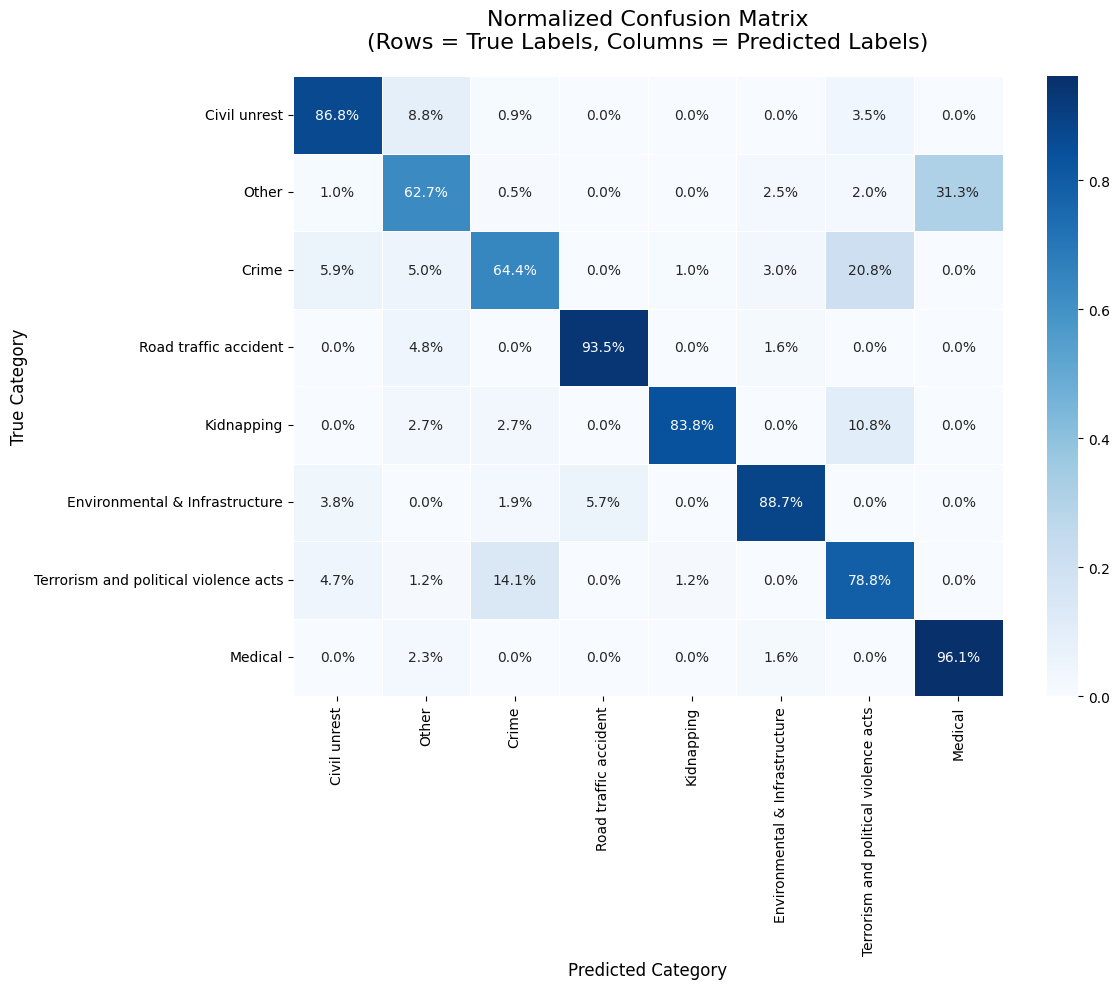

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix






cm = confusion_matrix(true_labels, llm_predictions, labels=categories)


cm_df = pd.DataFrame(cm, index=categories, columns=categories)

print("\nConfusion Matrix :")
print(cm_df)



cm_normalized = cm_df.div(cm_df.sum(axis=1), axis=0)





plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.1%',
    cmap='Blues',
    linewidths=.5
)


heatmap.set_title('Normalized Confusion Matrix\n(Rows = True Labels, Columns = Predicted Labels)', fontsize=16, pad=20)
heatmap.set_xlabel('Predicted Category', fontsize=12)
heatmap.set_ylabel('True Category', fontsize=12)


plt.tight_layout()
plt.show()

In [ ]:
test_df.head.to_excel("llama3_zeroshot_results_Z", index=False)

/tmp/ipython-input-28-281818268.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


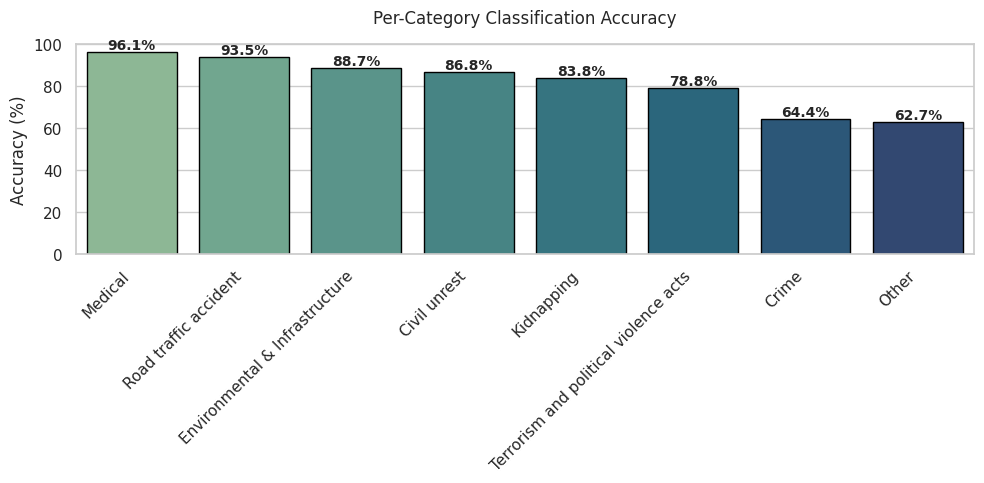

In [ ]:



per_cat_acc = (
    test_df
    .assign(correct=lambda d: d["LLM_Predicted"] == d["Category"])
    .groupby("Category")["correct"]
    .mean()
    .mul(100)
    .sort_values(ascending=False)
    .reset_index(name="accuracy")
)


sns.set_theme(style="whitegrid", font_scale=1.0)
palette = sns.color_palette("crest", len(per_cat_acc))


fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(
    data=per_cat_acc,
    x="Category", y="accuracy",
    palette=palette, edgecolor="black",
    ax=ax
)


for p in ax.patches:
    val = p.get_height()
    ax.annotate(f"{val:0.1f}%",
                (p.get_x() + p.get_width() / 2, val),
                ha="center", va="bottom",
                fontsize=10, fontweight="bold")


ax.set_ylabel("Accuracy ")
ax.set_xlabel("")
ax.set_ylim(0, 100)
ax.set_title("Per-Category Classification Accuracy", pad=15)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()